In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel


# For acquisition function
from scipy.stats import norm

In [7]:
# black-box function (unknown to you)
def black_box(x):
    return 1/(1+(x-1)**2) + 0.5/(1+(x-4)**2) + 0.8/(1+(x-7)**2)

In [8]:
X = np.array([[4.0]])
y = black_box(X.ravel())

# scale y-values
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# definition of kernel and GP
kernel = RBF(length_scale=0.5, length_scale_bounds=(0.2, 2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=20)

# fit GP
gp.fit(X, y_scaled)

print("length scale:", gp.kernel_.length_scale)

length scale: 0.5


In [11]:
# ucb acquisition function
def ucb(x, gp, beta=1.0):
    mu, sigma = gp.predict(x, return_std=True)
    return mu + beta * sigma


maximum of acquisition function: 1.0000 at x = 0.0000


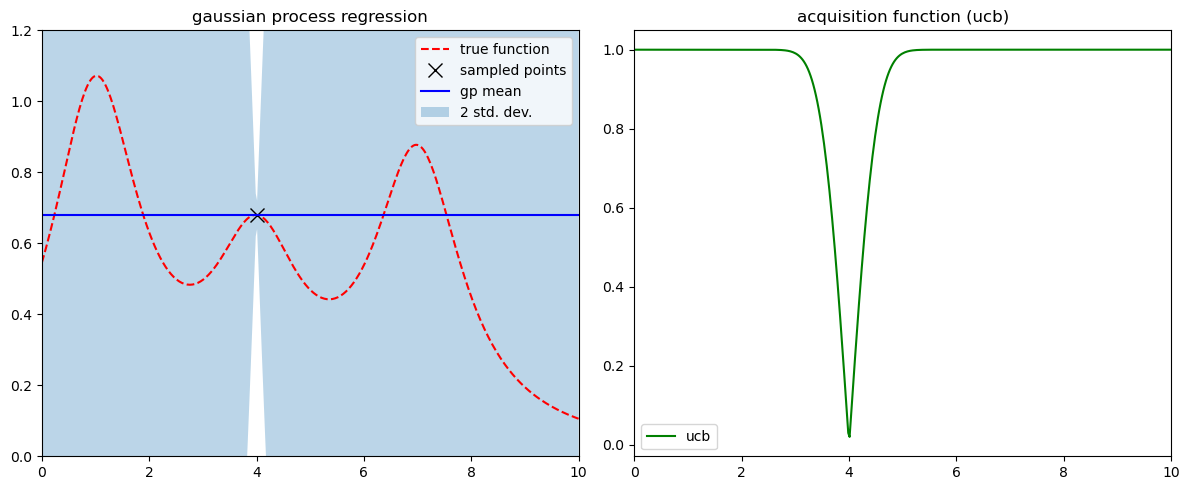

In [12]:
x_grid = np.linspace(0, 10, 400).reshape(-1, 1)

# true function (unknown to you)
y_true = np.array([black_box(xx[0]) for xx in x_grid])

# gaussian process prediction
y_pred, sigma = gp.predict(x_grid, return_std=True)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
sigma = sigma * scaler.scale_[0]  # rescale sigma back

# evaluation of acquisition function (ucb)
acq = ucb(x_grid, gp)
best_idx = np.argmax(acq)
x_next = x_grid[best_idx, 0]
ucb_max = acq[best_idx]
print(f"maximum of acquisition function: {ucb_max:.4f} at x = {x_next:.4f}")

# plot gpr
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, y_true, "r--", label="true function")
plt.plot(X, y, "kx", markersize=10, label="sampled points")
plt.plot(x_grid, y_pred, "b", label="gp mean")
plt.fill_between(
    x_grid.ravel(),
    y_pred - 2 * sigma,
    y_pred + 2 * sigma,
    alpha = 0.3,
    label="2 std. dev."
)
plt.title("gaussian process regression")
plt.legend()
plt.xlim([0, 10])
plt.ylim([0, 1.2])

# plot acquisition
plt.subplot(1, 2, 2)
plt.plot(x_grid, acq, "g", label="ucb")
plt.title("acquisition function (ucb)")
plt.legend()
plt.xlim([0, 10])

plt.tight_layout()
plt.show()